# Bayesian Neural Networks pour MNIST

**Objectif** : Comprendre et implémenter un BNN pour la classification d'images MNIST
- Partie 1 : Setup et chargement des données
- Partie 2 : Implémentation manuelle (Bayes by Backprop)
- Partie 3 : Bibliothèques spécialisées (Pyro, TensorFlow Probability)
- Partie 4 : Entrainement d'un CNN Bayesian Hybride


# PARTIE 1 : SETUP INITIAL

In [ ]:
!pip install pyro-ppl
!pip install tensorflow-probability
!pip install matplotlib seaborn
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration pour la reproductibilité
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé : {device}")

Device utilisé : cpu


# Chargement du dataset MNIST

Nombre d'échantillons d'entraînement : 60000
Nombre d'échantillons de test : 10000


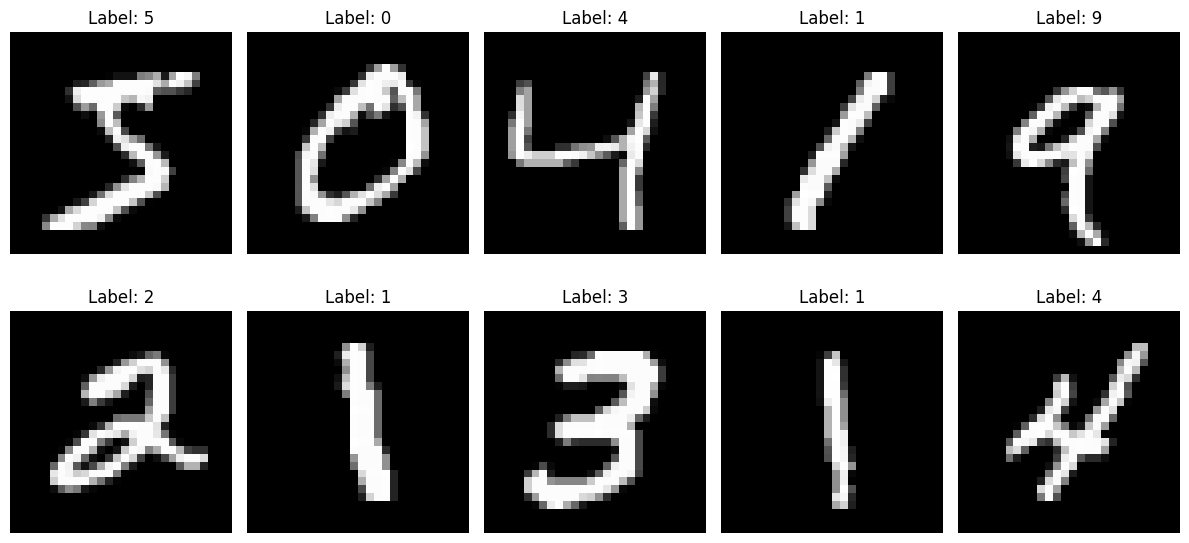

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Nombre d'échantillons d'entraînement : {len(train_dataset)}")
print(f"Nombre d'échantillons de test : {len(test_dataset)}")

# Visualisation de quelques échantillons
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, (img, label) in enumerate(train_dataset):
    if i >= 10:
        break
    row, col = i // 5, i % 5
    axes[row, col].imshow(img.squeeze(), cmap='gray')
    axes[row, col].set_title(f'Label: {label}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

# PARTIE 2 : IMPLÉMENTATION MANUELLE BNN

**Bayes by Backprop - Implémentation manuelle**

**Principe** :
1. Chaque poids w est modélisé par une distribution gaussienne N(μ, σ²)
2. On échantillonne les poids à chaque forward pass
3. La loss combine log-likelihood et KL divergence (ELBO)
4. Utilisation du reparametrization trick pour la backpropagation

In [ ]:
class BayesianLinear(nn.Module):
    """
    Couche linéaire bayésienne avec des poids probabilistes
    """
    def __init__(self, in_features, out_features, prior_mu=0, prior_sigma=1):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Paramètres du prior (distribution a priori)
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        self.prior_log_sigma = np.log(prior_sigma)

        # Paramètres variationnels pour les poids (posterior approximatif)
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))

        # Paramètres variationnels pour les biais
        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features))

        self.reset_parameters()

    def reset_parameters(self):
        """Initialisation des paramètres"""
        # Initialisation des moyennes
        nn.init.kaiming_uniform_(self.weight_mu, a=np.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight_mu)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.bias_mu, -bound, bound)

        # Initialisation des rho (paramètre pour sigma)
        nn.init.constant_(self.weight_rho, -5)
        nn.init.constant_(self.bias_rho, -5)

    def forward(self, x):
        """
        Forward pass avec échantillonnage des poids
        """
        # Conversion rho -> sigma via softplus
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))

        # Échantillonnage des poids (reparametrization trick)
        weight_eps = torch.randn_like(self.weight_mu)
        bias_eps = torch.randn_like(self.bias_mu)

        weight = self.weight_mu + weight_sigma * weight_eps
        bias = self.bias_mu + bias_sigma * bias_eps

        # Calcul de la KL divergence
        self.kl_divergence = self._kl_divergence(
            self.weight_mu, weight_sigma, self.bias_mu, bias_sigma
        )

        return F.linear(x, weight, bias)

    def _kl_divergence(self, weight_mu, weight_sigma, bias_mu, bias_sigma):
        """
        Calcul de la KL divergence entre posterior et prior
        KL(q(w|θ) || p(w)) pour une gaussienne
        """
        # KL pour les poids
        kl_weight = 0.5 * torch.sum(
            2 * self.prior_log_sigma - 2 * torch.log(weight_sigma) +
            (weight_sigma.pow(2) + (weight_mu - self.prior_mu).pow(2)) /
            (self.prior_sigma ** 2) - 1
        )

        # KL pour les biais
        kl_bias = 0.5 * torch.sum(
            2 * self.prior_log_sigma - 2 * torch.log(bias_sigma) +
            (bias_sigma.pow(2) + (bias_mu - self.prior_mu).pow(2)) /
            (self.prior_sigma ** 2) - 1
        )

        return kl_weight + kl_bias

In [ ]:
class BayesianMLP(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=100, output_dim=10):
        super().__init__()
        self.fc1 = BayesianLinear(input_dim, hidden_dim)
        self.fc2 = BayesianLinear(hidden_dim, output_dim)

    def forward(self, x):
        # Aplatissement de l'image
        x = x.view(x.size(0), -1)

        # Forward pass
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        # Somme des KL divergences
        self.kl_divergence = self.fc1.kl_divergence + self.fc2.kl_divergence

        return x

    def predict_with_uncertainty(self, x, num_samples=100, return_samples=False):
        """
        Prédiction avec estimation d'incertitude.
        Si return_samples=True, renvoie aussi les échantillons de prédiction
        """
        self.train()  # important pour échantillonner à chaque forward
        predictions = []

        with torch.no_grad():
            for _ in range(num_samples):
                pred = torch.softmax(self.forward(x), dim=1)
                predictions.append(pred.cpu().numpy())

        predictions = np.array(predictions)
        mean_pred = np.mean(predictions, axis=0)
        var_pred = np.var(predictions, axis=0)

        if return_samples:
            return mean_pred, var_pred, predictions
        else:
            return mean_pred, var_pred

In [ ]:
# Fonction de loss ELBO

def elbo_loss(outputs, targets, kl_divergence, num_batches):
    """
    Evidence Lower BOund (ELBO) loss
    ELBO = Log-likelihood - KL divergence
    """
    # Log-likelihood (negative cross-entropy)
    log_likelihood = -F.cross_entropy(outputs, targets, reduction='sum')

    # KL divergence normalisée par le nombre de batches
    kl_term = kl_divergence / num_batches

    # ELBO = maximiser log-likelihood - minimiser KL
    # Donc loss = -log_likelihood + KL
    elbo = -log_likelihood + kl_term

    return elbo, log_likelihood, kl_term

In [ ]:
# Entraînement du BNN manuel

# Initialisation du modèle
bnn_model = BayesianMLP().to(device)
optimizer = optim.Adam(bnn_model.parameters(), lr=0.001)

num_epochs = 10
num_batches = len(train_loader)

# Métriques de suivi
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    bnn_model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # Forward pass
        output = bnn_model(data)

        # Calcul de la loss ELBO
        loss, log_likelihood, kl_term = elbo_loss(
            output, target, bnn_model.kl_divergence, num_batches
        )

        # Backward pass
        loss.backward()
        optimizer.step()

        # Métriques
        epoch_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        # Mise à jour de la barre de progression
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'LL': f'{log_likelihood.item():.2f}',
            'KL': f'{kl_term.item():.2f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })

    # Sauvegarde des métriques
    avg_loss = epoch_loss / len(train_loader)
    accuracy = 100. * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={accuracy:.2f}%')

Epoch 1/10: 100%|██████████| 469/469 [00:26<00:00, 17.52it/s, Loss=718.3715, LL=-13.08, KL=705.29, Acc=90.54%]


Epoch 1: Loss=776.5041, Accuracy=90.54%


Epoch 2/10: 100%|██████████| 469/469 [00:25<00:00, 18.33it/s, Loss=655.1063, LL=-9.84, KL=645.27, Acc=95.48%]


Epoch 2: Loss=694.3779, Accuracy=95.48%


Epoch 3/10: 100%|██████████| 469/469 [00:26<00:00, 17.64it/s, Loss=599.5925, LL=-11.93, KL=587.67, Acc=96.80%]


Epoch 3: Loss=629.7421, Accuracy=96.80%


Epoch 4/10: 100%|██████████| 469/469 [00:24<00:00, 18.87it/s, Loss=541.3132, LL=-6.65, KL=534.67, Acc=97.47%]


Epoch 4: Loss=571.4688, Accuracy=97.47%


Epoch 5/10: 100%|██████████| 469/469 [00:25<00:00, 18.73it/s, Loss=505.1327, LL=-17.66, KL=487.47, Acc=97.78%]


Epoch 5: Loss=519.6362, Accuracy=97.78%


Epoch 6/10: 100%|██████████| 469/469 [00:25<00:00, 18.58it/s, Loss=452.1106, LL=-5.34, KL=446.77, Acc=98.01%]


Epoch 6: Loss=474.6783, Accuracy=98.01%


Epoch 7/10: 100%|██████████| 469/469 [00:24<00:00, 19.07it/s, Loss=420.3180, LL=-8.15, KL=412.16, Acc=98.14%]


Epoch 7: Loss=436.3819, Accuracy=98.14%


Epoch 8/10: 100%|██████████| 469/469 [00:25<00:00, 18.61it/s, Loss=386.4406, LL=-3.27, KL=383.17, Acc=98.10%]


Epoch 8: Loss=404.4982, Accuracy=98.10%


Epoch 9/10: 100%|██████████| 469/469 [00:24<00:00, 18.87it/s, Loss=364.7304, LL=-5.92, KL=358.81, Acc=98.21%]


Epoch 9: Loss=377.5053, Accuracy=98.21%


Epoch 10/10: 100%|██████████| 469/469 [00:25<00:00, 18.39it/s, Loss=342.9256, LL=-5.19, KL=337.74, Acc=98.21%]

Epoch 10: Loss=354.8291, Accuracy=98.21%


In [ ]:
# Évaluation avec incertitude

def evaluate_with_uncertainty(model, data_loader, num_samples=50, return_samples=False):
    """
    Évaluation avec estimation d'incertitude
    """
    model.eval()
    all_predictions = []
    all_uncertainties = []
    all_targets = []
    all_confidences = []
    all_mean_preds = []
    all_samples = []

    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in tqdm(data_loader, desc='Évaluation'):
            data, target = data.to(device), target.to(device)

            if return_samples:
                mean_pred, var_pred, samples = model.predict_with_uncertainty(data, num_samples, return_samples=True)
                all_samples.append(samples)
            else:
                mean_pred, var_pred = model.predict_with_uncertainty(data, num_samples)

            predicted = np.argmax(mean_pred, axis=1)
            entropy = -np.sum(mean_pred * np.log(mean_pred + 1e-8), axis=1)
            confidence = np.max(mean_pred, axis=1)

            all_predictions.extend(predicted)
            all_uncertainties.extend(entropy)
            all_confidences.extend(confidence)
            all_targets.extend(target.cpu().numpy())
            all_mean_preds.append(mean_pred)

            correct += (predicted == target.cpu().numpy()).sum()
            total += target.size(0)

    accuracy = 100. * correct / total
    print(f'Accuracy BNN manuel : {accuracy:.2f}%')

    all_mean_preds = np.vstack(all_mean_preds)
    all_uncertainties = np.array(all_uncertainties)
    all_confidences = np.array(all_confidences)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    if return_samples:
        all_samples = np.concatenate(all_samples, axis=1)
        return all_predictions, all_uncertainties, all_targets, all_confidences, all_mean_preds, all_samples
    else:
        return all_predictions, all_uncertainties, all_targets, all_confidences, all_mean_preds


In [ ]:
predictions, uncertainties, targets, confidences, mean_preds, samples = evaluate_with_uncertainty(
    bnn_model, test_loader, num_samples=50, return_samples=True
)

Évaluation: 100%|██████████| 79/79 [00:16<00:00,  4.72it/s]

Accuracy BNN manuel : 97.78%


In [ ]:
def compute_nll(mean_pred, targets):
    true_probs = mean_pred[np.arange(len(targets)), targets]
    return -np.mean(np.log(true_probs + 1e-8))

def compute_ece(confidences, predictions, labels, n_bins=15):
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        bin_mask = (confidences > bins[i]) & (confidences <= bins[i + 1])
        if np.any(bin_mask):
            accuracy = np.mean(predictions[bin_mask] == labels[bin_mask])
            avg_confidence = np.mean(confidences[bin_mask])
            ece += (np.sum(bin_mask) / len(labels)) * abs(avg_confidence - accuracy)
    return ece

def mutual_information(samples):
    expected_entropy = -np.mean(np.sum(samples * np.log(samples + 1e-8), axis=2), axis=0)
    entropy_of_mean = -np.sum(np.mean(samples, axis=0) * np.log(np.mean(samples, axis=0) + 1e-8), axis=1)
    return entropy_of_mean - expected_entropy

nll = compute_nll(mean_preds, targets)
ece = compute_ece(confidences, predictions, targets)
mi = mutual_information(samples)
mean_mi = np.mean(mi)
mean_conf = np.mean(confidences)

print("\n Résumé des métriques bayésiennes :")
print(f"- Accuracy                       : {100. * np.mean(predictions == targets):.2f}%")
print(f"- Confidence moyenne             : {mean_conf:.4f}")
print(f"- Negative Log-Likelihood (NLL) : {nll:.4f}")
print(f"- Calibration (ECE)             : {ece:.4f}")
print(f"- Mutual Information (épist.)   : {mean_mi:.4f}")



 Résumé des métriques bayésiennes :
- Accuracy                       : 97.78%
- Confidence moyenne             : 0.9733
- Negative Log-Likelihood (NLL) : 0.0707
- Calibration (ECE)             : 0.0055
- Mutual Information (épist.)   : 0.0216


# PARTIE 3 : BIBLIOTHÈQUES SPÉCIALISÉES

**Panorama des bibliothèques probabilistes**

1. **Pyro** (PyTorch-based)
2. **TensorFlow Probability**
3. **NumPyro**

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.poutine as poutine


class PyroMLP(PyroModule):
    """
    MLP bayésien avec Pyro (plus concis et élégant)
    """
    def __init__(self, input_dim=784, hidden_dim=100, output_dim=10):
        super().__init__()

        # Définition des couches avec priors
        self.fc1 = PyroModule[nn.Linear](input_dim, hidden_dim)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([hidden_dim, input_dim]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([hidden_dim]).to_event(1))

        self.fc2 = PyroModule[nn.Linear](hidden_dim, output_dim)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([output_dim, hidden_dim]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([output_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        logits = self.fc2(x)

        # Likelihood
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=logits), obs=y)

        return logits

In [ ]:
from pyro.infer.autoguide import AutoDiagonalNormal

pyro_model = PyroMLP().to(device)
guide = AutoDiagonalNormal(pyro_model)

# Optimiseur et inférence variationnelle
adam = Adam({"lr": 0.01})
svi = SVI(pyro_model, guide, adam, loss=Trace_ELBO())

In [ ]:
# Entraînement Pyro
pyro_losses = []

for epoch in range(10):
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Pyro Epoch {epoch+1}')):
        data, target = data.to(device), target.to(device)
        loss = svi.step(data, target)
        epoch_loss += loss

    avg_loss = epoch_loss / len(train_loader)
    pyro_losses.append(avg_loss)
    print(f'Pyro Epoch {epoch+1}: Loss = {avg_loss:.4f}')

Pyro Epoch 1: 100%|██████████| 469/469 [00:29<00:00, 16.05it/s]


Pyro Epoch 1: Loss = 2613.1381


Pyro Epoch 2: 100%|██████████| 469/469 [00:28<00:00, 16.18it/s]


Pyro Epoch 2: Loss = 2631.1251


Pyro Epoch 3: 100%|██████████| 469/469 [00:28<00:00, 16.28it/s]


Pyro Epoch 3: Loss = 2612.3142


Pyro Epoch 4: 100%|██████████| 469/469 [00:28<00:00, 16.26it/s]


Pyro Epoch 4: Loss = 2595.0975


Pyro Epoch 5: 100%|██████████| 469/469 [00:28<00:00, 16.36it/s]


Pyro Epoch 5: Loss = 2597.0008


Pyro Epoch 6: 100%|██████████| 469/469 [00:29<00:00, 15.92it/s]


Pyro Epoch 6: Loss = 2616.3804


Pyro Epoch 7: 100%|██████████| 469/469 [00:28<00:00, 16.44it/s]


Pyro Epoch 7: Loss = 2630.2209


Pyro Epoch 8: 100%|██████████| 469/469 [00:28<00:00, 16.58it/s]


Pyro Epoch 8: Loss = 2614.6684


Pyro Epoch 9: 100%|██████████| 469/469 [00:28<00:00, 16.47it/s]


Pyro Epoch 9: Loss = 2607.0285


Pyro Epoch 10: 100%|██████████| 469/469 [00:28<00:00, 16.57it/s]

Pyro Epoch 10: Loss = 2607.2413


In [ ]:
def pyro_predict_with_uncertainty(model, guide, x, num_samples=50, return_samples=False):
    """
    Prédiction avec estimation d'incertitude via Pyro
    """
    model.eval()
    x = x.view(x.size(0), -1)
    predictions = []

    for _ in range(num_samples):
        sampled_params = guide()
        conditioned_model = pyro.poutine.condition(model, data=sampled_params)
        with torch.no_grad():
            logits = conditioned_model(x)
            probs = torch.softmax(logits, dim=1)
            predictions.append(probs.cpu().numpy())

    predictions = np.stack(predictions)
    mean_pred = predictions.mean(axis=0)
    var_pred = predictions.var(axis=0)

    if return_samples:
        return mean_pred, var_pred, predictions
    else:
        return mean_pred, var_pred


In [ ]:
from sklearn.metrics import log_loss

def evaluate_pyro(model, guide, data_loader, num_samples=50, return_samples=False):
    """
    Évaluation du modèle Pyro avec incertitude et métriques BNN
    """
    model.eval()
    all_predictions = []
    all_uncertainties = []
    all_targets = []
    all_confidences = []
    all_mean_preds = []
    all_samples = [] if return_samples else None

    correct = 0
    total = 0

    for data, target in tqdm(data_loader, desc='Évaluation Pyro'):
        data, target = data.to(device), target.to(device)

        if return_samples:
            mean_pred, var_pred, samples = pyro_predict_with_uncertainty(model, guide, data, num_samples, return_samples=True)
            all_samples.append(samples)
        else:
            mean_pred, var_pred = pyro_predict_with_uncertainty(model, guide, data, num_samples)

        pred_class = np.argmax(mean_pred, axis=1)
        entropy = -np.sum(mean_pred * np.log(mean_pred + 1e-8), axis=1)
        confidence = np.max(mean_pred, axis=1)

        correct += (pred_class == target.cpu().numpy()).sum()
        total += target.size(0)

        all_predictions.extend(pred_class)
        all_uncertainties.extend(entropy)
        all_confidences.extend(confidence)
        all_mean_preds.extend(mean_pred)
        all_targets.extend(target.cpu().numpy())

    accuracy = 100. * correct / total
    print(f"Accuracy : {accuracy:.2f}%")

    return {
        'predictions': np.array(all_predictions),
        'uncertainties': np.array(all_uncertainties),
        'targets': np.array(all_targets),
        'confidences': np.array(all_confidences),
        'mean_preds': np.array(all_mean_preds),
        'samples': np.concatenate(all_samples, axis=1) if return_samples else None
    }


In [ ]:
results_pyro = evaluate_pyro(pyro_model, guide, test_loader, num_samples=50, return_samples=True)

preds = results_pyro['predictions']
targets = results_pyro['targets']
confidences = results_pyro['confidences']
mean_preds = results_pyro['mean_preds']

from sklearn.metrics import log_loss

accuracy = 100. * (preds == targets).sum() / len(targets)
nll = log_loss(targets, mean_preds)
confidence_avg = np.mean(confidences)

# Affichage
print("MÉTRIQUES")
print(f"Accuracy                      : {accuracy:.2f} %")
print(f"Negative Log-Likelihood (NLL) : {nll:.4f}")
print(f"Confiance moyenne             : {confidence_avg:.4f}")

Évaluation Pyro: 100%|██████████| 79/79 [00:25<00:00,  3.10it/s]

Accuracy : 69.18%
MÉTRIQUES
Accuracy                      : 69.18 %
Negative Log-Likelihood (NLL) : 1.0915
Confiance moyenne             : 0.4832


# Partie 4 : Entrainement d'un CNN Bayesien Hybride

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
])


NUM_CLASSES = 10


In [ ]:
# Charger KMNIST
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

In [ ]:
kmnist_dataset = datasets.KMNIST(root="./data", train=True, download=True, transform=transform)

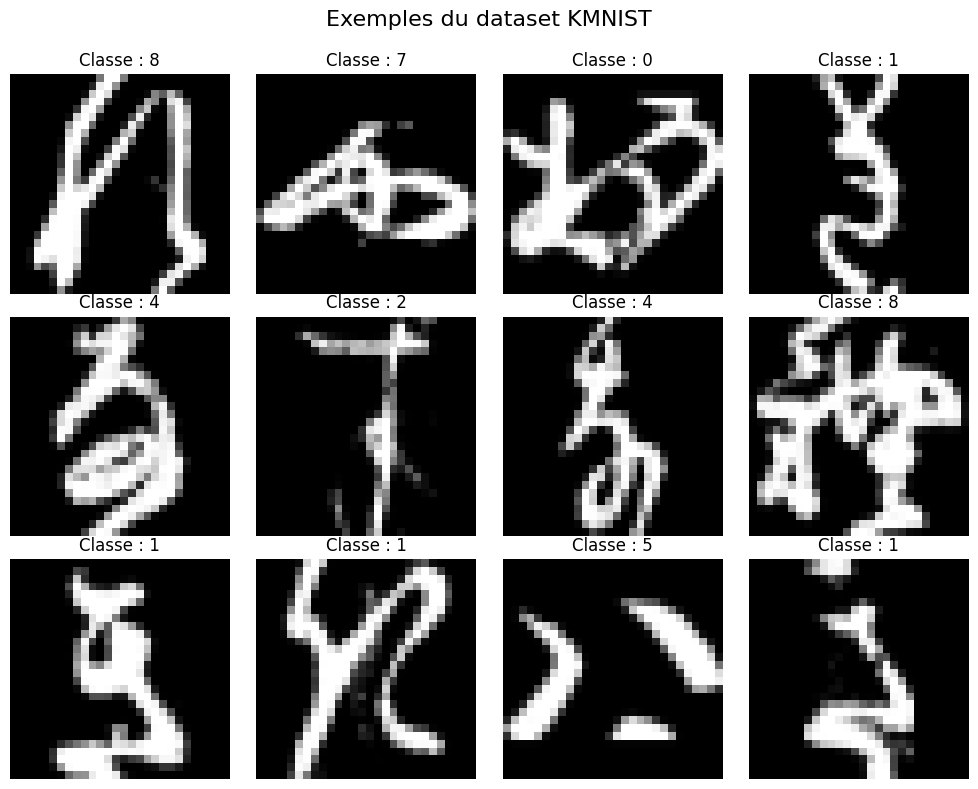

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(10, 8))
for i in range(12):
    image, label = kmnist_dataset[i]
    ax = axes[i // 4, i % 4]
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(f"Classe : {label}")
    ax.axis("off")

plt.tight_layout()
plt.suptitle("Exemples du dataset KMNIST", fontsize=16)
plt.subplots_adjust(top=0.90)
plt.show()

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
kmnist_loader = DataLoader(kmnist_dataset, batch_size=256, shuffle=False)

In [ ]:
class ClassicCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            self.flatten_dim = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.fc2 = nn.Linear(128, NUM_CLASSES)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
def train_classic(model, optimizer, loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total = 0
        correct = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = F.cross_entropy(output, y)
            loss.backward()
            optimizer.step()
            total += y.size(0)
            correct += (output.argmax(1) == y).sum().item()
        acc = correct / total
        print(f"[Classic CNN] Epoch {epoch+1} - Accuracy: {acc:.4f}")

In [ ]:
classic_model = ClassicCNN().to(device)
optimizer = torch.optim.Adam(classic_model.parameters(), lr=1e-3)
train_classic(classic_model, optimizer, train_loader)

[Classic CNN] Epoch 1 - Accuracy: 0.9242
[Classic CNN] Epoch 2 - Accuracy: 0.9795
[Classic CNN] Epoch 3 - Accuracy: 0.9862
[Classic CNN] Epoch 4 - Accuracy: 0.9886
[Classic CNN] Epoch 5 - Accuracy: 0.9911


In [ ]:
class BayesianCNN(PyroModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            self.flatten_dim = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flatten_dim, 128)

        # Couche bayésienne
        self.fc2 = PyroModule[nn.Linear](128, NUM_CLASSES)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([NUM_CLASSES, 128]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([NUM_CLASSES]).to_event(1))

    def forward(self, x, y=None):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        return logits


In [ ]:
bnn = BayesianCNN().to(device)

guide = pyro.infer.autoguide.AutoDiagonalNormal(bnn)
optimizer_bnn = Adam({"lr": 1e-3})
svi = SVI(bnn, guide, optimizer_bnn, loss=Trace_ELBO())

def train_bnn(epochs=20):
    pyro.clear_param_store()
    for epoch in range(epochs):
        total_loss = 0.
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            loss = svi.step(x, y)
            total_loss += loss
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"[BNN] Epoch {epoch+1} - Loss: {avg_loss:.4f}")

train_bnn()

[BNN] Epoch 1 - Loss: 16.5866
[BNN] Epoch 2 - Loss: 12.1625
[BNN] Epoch 3 - Loss: 8.4616
[BNN] Epoch 4 - Loss: 5.4792
[BNN] Epoch 5 - Loss: 3.3716
[BNN] Epoch 6 - Loss: 2.0395
[BNN] Epoch 7 - Loss: 1.3144
[BNN] Epoch 8 - Loss: 0.9730
[BNN] Epoch 9 - Loss: 0.7964
[BNN] Epoch 10 - Loss: 0.7139
[BNN] Epoch 11 - Loss: 0.6415
[BNN] Epoch 12 - Loss: 0.6095
[BNN] Epoch 13 - Loss: 0.5850
[BNN] Epoch 14 - Loss: 0.5738
[BNN] Epoch 15 - Loss: 0.5502
[BNN] Epoch 16 - Loss: 0.5402
[BNN] Epoch 17 - Loss: 0.5292
[BNN] Epoch 18 - Loss: 0.5304
[BNN] Epoch 19 - Loss: 0.5149
[BNN] Epoch 20 - Loss: 0.5067


In [ ]:
train_bnn(epochs=10)

[BNN] Epoch 1 - Loss: 0.5005
[BNN] Epoch 2 - Loss: 0.5059
[BNN] Epoch 3 - Loss: 0.4934
[BNN] Epoch 4 - Loss: 0.4912
[BNN] Epoch 5 - Loss: 0.4839
[BNN] Epoch 6 - Loss: 0.4767
[BNN] Epoch 7 - Loss: 0.4785
[BNN] Epoch 8 - Loss: 0.4687
[BNN] Epoch 9 - Loss: 0.4674
[BNN] Epoch 10 - Loss: 0.4724
[BNN] Epoch 11 - Loss: 0.4368
[BNN] Epoch 12 - Loss: 0.4513
[BNN] Epoch 13 - Loss: 0.4560
[BNN] Epoch 14 - Loss: 0.4342
[BNN] Epoch 15 - Loss: 0.4407
[BNN] Epoch 16 - Loss: 0.4395
[BNN] Epoch 17 - Loss: 0.4272
[BNN] Epoch 18 - Loss: 0.4325
[BNN] Epoch 19 - Loss: 0.4225
[BNN] Epoch 20 - Loss: 0.4265


In [ ]:
# Fonction prédiction SVI (posterior sampling)
def predict_bnn(x, n_samples=20):
    bnn.eval()
    predictive = pyro.infer.Predictive(bnn, guide=guide, num_samples=n_samples,
                                       return_sites=["_RETURN"])
    samples = predictive(x.to(device))["_RETURN"]
    probs = torch.softmax(samples, dim=-1)
    mean_probs = probs.mean(dim=0)
    var_probs = probs.var(dim=0).mean(dim=1)
    return mean_probs, var_probs

def evaluate(model, loader, is_bnn=False):
    model.eval()
    total = 0
    correct = 0
    uncertainties = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            if is_bnn:
                preds, var = predict_bnn(x)
                uncertainties += var.cpu().tolist()
            else:
                preds = torch.softmax(model(x), dim=-1)
            total += y.size(0)
            correct += (preds.argmax(1) == y).sum().item()
    acc = correct / total
    return acc, uncertainties

In [ ]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)
    return total_correct / total_samples

In [ ]:
from pyro.infer import Predictive

def evaluate_bnn_accuracy(model, guide, dataloader, n_samples=20):
    model.eval()
    total_correct = 0
    total_samples = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        predictive = Predictive(model, guide=guide, num_samples=n_samples, return_sites=["_RETURN"])
        samples = predictive(x)["_RETURN"]  # (n_samples, batch, classes)
        probs = torch.softmax(samples, dim=-1)
        mean_probs = probs.mean(dim=0)
        preds = mean_probs.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_samples += y.size(0)
    return total_correct / total_samples

In [ ]:
def show_ood_examples(classic_model, bnn_model, guide, dataloader, n_samples=30, max_examples=10):
    classic_model.eval()
    bnn_model.eval()
    examples_shown = 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        batch_size = y.size(0)

        # CNN classique
        with torch.no_grad():
            logits_classic = classic_model(x)
            probs_classic = torch.softmax(logits_classic, dim=1)
            preds_classic = probs_classic.argmax(dim=1)
            conf_classic = probs_classic.max(dim=1).values

        # BNN
        predictive = Predictive(bnn_model, guide=guide, num_samples=n_samples, return_sites=["_RETURN"])
        samples = predictive(x)["_RETURN"]  # (n_samples, batch, classes)
        probs_bnn = torch.softmax(samples, dim=-1)
        mean_probs_bnn = probs_bnn.mean(dim=0)
        var_probs_bnn = probs_bnn.var(dim=0).mean(dim=1)  # incertitude moyenne par exemple
        preds_bnn = mean_probs_bnn.argmax(dim=1)
        conf_bnn = mean_probs_bnn.max(dim=1).values

        for i in range(batch_size):
            if examples_shown >= max_examples:
                return
            print(f"\nExemple #{examples_shown+1}:")
            print(f" CNN classique  : Prédit {preds_classic[i].item()} avec prob {conf_classic[i].item():.3f}")
            print(f" BNN           : Prédit {preds_bnn[i].item()} avec prob {conf_bnn[i].item():.3f} et incertitude {var_probs_bnn[i].item():.4f}")
            examples_shown += 1

In [ ]:
acc_classic_seen = evaluate_accuracy(classic_model, test_loader)
acc_bnn_seen = evaluate_bnn_accuracy(bnn, guide, test_loader)

print(f"Accuracy CNN classique sur classes apprises  : {acc_classic_seen:.4f}")
print(f"Accuracy BNN sur classes apprises            : {acc_bnn_seen:.4f}")

print("\n--- Exemples sur classes non apprises ---")
show_ood_examples(classic_model, bnn, guide, kmnist_loader, n_samples=200, max_examples=10)

Accuracy CNN classique sur classes apprises  : 0.9891
Accuracy BNN sur classes apprises            : 0.9935

--- Exemples sur classes non apprises ---

Exemple #1:
 CNN classique  : Prédit 4 avec prob 0.993
 BNN           : Prédit 4 avec prob 0.936 et incertitude 0.0073

Exemple #2:
 CNN classique  : Prédit 2 avec prob 0.802
 BNN           : Prédit 6 avec prob 0.307 et incertitude 0.0176

Exemple #3:
 CNN classique  : Prédit 5 avec prob 0.571
 BNN           : Prédit 6 avec prob 0.837 et incertitude 0.0081

Exemple #4:
 CNN classique  : Prédit 3 avec prob 0.910
 BNN           : Prédit 3 avec prob 0.438 et incertitude 0.0251

Exemple #5:
 CNN classique  : Prédit 2 avec prob 0.971
 BNN           : Prédit 2 avec prob 0.826 et incertitude 0.0096

Exemple #6:
 CNN classique  : Prédit 3 avec prob 0.828
 BNN           : Prédit 1 avec prob 0.430 et incertitude 0.0138

Exemple #7:
 CNN classique  : Prédit 5 avec prob 0.653
 BNN           : Prédit 8 avec prob 0.454 et incertitude 0.0188

Exemple 

In [ ]:
# === Sauvegarde ===

# CNN classique
torch.save(classic_model.state_dict(), "classic_cnn.pth")

# BNN Pyro
torch.save(bnn.state_dict(), "bnn_pyro.pth")

# Guide Pyro
torch.save(guide.state_dict(), "guide.pth")

print("Modèles sauvegardés avec succès !")

Modèles sauvegardés avec succès !


In [ ]:
# === Rechargement ===

classic_model = ClassicCNN()
classic_model.load_state_dict(torch.load("classic_cnn.pth"))
classic_model.to(device)
classic_model.eval()

bnn = BayesianCNN()
bnn.load_state_dict(torch.load("bnn_pyro.pth"))
bnn.to(device)
bnn.eval()

guide = pyro.infer.autoguide.AutoDiagonalNormal(bnn)
guide.load_state_dict(torch.load("guide.pth"), strict=False)

print("Modèles rechargés avec succès !")

Modèles rechargés avec succès !


# RÉSUMÉ ET CONCLUSIONS


**Ce que nous avons implémenté :**

1. **BNN Manuel (Bayes by Backprop)** :

2. **BNN avec Pyro** :

**Avantages/Inconvénients** :

**Implémentation manuelle** :
- Contrôle total, compréhension profonde
- Plus de code, plus d'erreurs possibles

**Bibliothèques (Pyro) ou autres** :
- Code concis, moins d'erreurs, optimisations
- Moins de contrôle, courbe d'apprentissage

**Pour aller plus loin** :
- Essayer MCMC pour une inférence exacte
- Explorer d'autres approximations
- etc...


**Ressources supplémentaires**

- [notebook 1](https://colab.research.google.com/github/charlesollion/dlexperiments/blob/master/6-Bayesian-DL/BayesianDeepWine.ipynb
)

- [notebook 2](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html)